In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [18]:
# 하이퍼 파라미터
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension': 1}

In [13]:
# 모델 생성 클래스
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                       kernel_size=kernel_size,
                                       padding='valid',
                                       activation=relu,
                                       kernel_constraint=MaxNorm(max_value=3.))
                                         for kernel_size in [3,4,5]]
    
        self.pooling = GlobalMaxPooling1D()
        self.dropout = Dropout(kargs['dropout_rate'])
        self.fc1 = Dense(units=kargs['hidden_dimension'], activation=relu, kernel_constraint=MaxNorm(max_value=3.))
        self.fc2 = Dense(units=kargs['output_dimension'], activation=sigmoid, kernel_constraint=MaxNorm(max_value=3.))
        
    
    def call(self, x) :
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [15]:
model = CNNClassifier(**kargs)
model.compile(optimizer=Adam(1e-4),
             loss=BinaryCrossentropy(),
             metrics=[BinaryAccuracy(name='accuracy')])

In [16]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_en -- Folder create complete 



In [19]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
44/44 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5932
Epoch 1: val_accuracy did not improve from 0.65080
44/44 [==============================] - 57s 1s/step - loss: 0.6880 - accuracy: 0.5932 - val_loss: 0.6845 - val_accuracy: 0.6108
Epoch 2/5
44/44 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.6743
Epoch 2: val_accuracy improved from 0.65080 to 0.73800, saving model to ./data_out/cnn_classifier_en\weights.h5
44/44 [==============================] - 54s 1s/step - loss: 0.6812 - accuracy: 0.6743 - val_loss: 0.6732 - val_accuracy: 0.7380
Epoch 3/5
44/44 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7204
Epoch 3: val_accuracy improved from 0.73800 to 0.75280, saving model to ./data_out/cnn_classifier_en\weights.h5
44/44 [==============================] - 54s 1s/step - loss: 0.6626 - accuracy: 0.7204 - val_loss: 0.6421 - val_accuracy: 0.7528
Epoch 4/5
44/44 [==============================] - ETA: 0s 

In [21]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

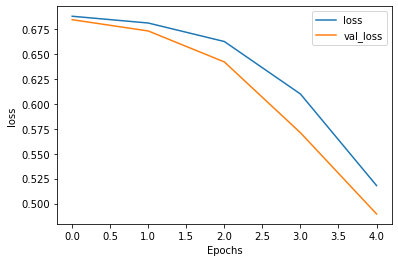

In [23]:
plot_graphs(history, 'loss')

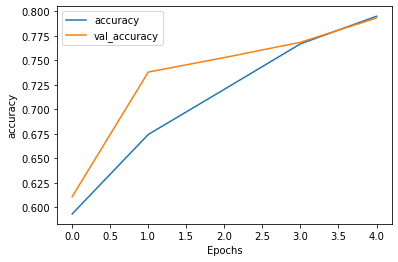

In [24]:
plot_graphs(history, 'accuracy')

In [29]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'


test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [30]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [31]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [32]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)